In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### **Algoritmos a probar**

**Linear**
* Logistic Regression
* Linear SVC (regularized - unregularized)

**Non-linear**
* Poly SVC
* rbf SVC

**otros**
* naïve Bayes
* Nearest Neighbors Classification
* Stochastic Gradient Descent
* Gaussian Process Classification
* Decision Trees

**Ensambles**
* Random Forests
* AdaBoost
* Gradient Tree Boosting

**Neural Network**
* Multi-layer Perceptron

### Pre-procesamiento de datos

In [2]:
%%time
# Cargo datos parte1
avisos_parte1 =  pd.read_csv('../data/datos_navent_fiuba/fiuba_6_avisos_detalle.csv')
postulaciones_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_4_postulaciones.csv')
vistas_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_3_vistas.csv')
edadYGenero_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv')
educacion_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_1_postulantes_educacion.csv')

# Cargo datos hasta 15_4
avisos_hasta15_4 =  pd.read_csv('./data/Fiuba hasta 15 Abril/fiuba_6_avisos_detalle.csv')
postulaciones_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_4_postulaciones.csv')
vistas_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_3_vistas.csv')
edadYGenero_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_2_postulantes_genero_y_edad.csv')
educacion_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_1_postulantes_educacion.csv')

# Concateno la info
avisos = pd.concat([avisos_parte1, avisos_hasta15_4])
postulaciones = pd.concat([postulaciones_parte1, postulaciones_hasta15_4])
vistas = pd.concat([vistas_parte1, vistas_hasta15_4])
edadYGenero = pd.concat([edadYGenero_parte1, edadYGenero_hasta15_4])
educacion = pd.concat([educacion_parte1, educacion_hasta15_4])

# Elimino las referencias a sets que ya no necesito
del(avisos_hasta15_4,
    avisos_parte1,
    postulaciones_hasta15_4,
    postulaciones_parte1,
    vistas_hasta15_4,
    vistas_parte1,
    edadYGenero_hasta15_4,
    edadYGenero_parte1,
    educacion_hasta15_4,
    educacion_parte1)

# Guardo una lista con los datasets
data = [avisos, postulaciones, vistas, edadYGenero, educacion]

# Elimino duplicados
for df in data:
  if(df.duplicated().any().any()):
    df.drop_duplicates(inplace=True)

# Reseteo los index
for df in data:
  df.reset_index(drop=True, inplace=True)

# Remuevo columnas innecesarias
avisos.drop(columns=['idpais','ciudad','mapacalle'], inplace=True)

# Renombro columnas
educacion.rename(columns={'nombre':'nivel'}, inplace=True)
vistas.rename(columns={'idAviso':'idaviso','timestamp':'fechavista'}, inplace=True)

CPU times: user 1min 6s, sys: 5.39 s, total: 1min 11s
Wall time: 1min 12s


In [3]:
%%time
# Veo que set y columnas tiene datos faltantes
datos = {'avisos': avisos, 'postulaciones': postulaciones, 'vistas': vistas, 'edadYGenero': edadYGenero, 'educacion': educacion}
for name, df in datos.items():
  cols_con_nulls = df.isnull().any()
  print(f"[{name}]",cols_con_nulls.any())
  if cols_con_nulls.any():
    cols = df.columns[cols_con_nulls.values][0]
    print('  columnas ->',cols)
    for column in [cols]:
      print(f'  tasa[{column}]:', len(df[df[[column]].isnull().values])/len(df))
  print()

[avisos] True
  columnas -> denominacion_empresa
  tasa[denominacion_empresa]: 0.0003048006096012192

[postulaciones] False

[vistas] False

[edadYGenero] True
  columnas -> fechanacimiento
  tasa[fechanacimiento]: 0.04809377846111661

[educacion] False

CPU times: user 3.82 s, sys: 89.7 ms, total: 3.91 s
Wall time: 3.91 s


In [4]:
%%time
# AVISOS
# Analizo cols con nulls
if(avisos.isna().any().any()):
  cols_con_nulls = avisos.columns[avisos.isna().any().values]
  for col in cols_con_nulls:
    print(col)
    print(avisos[col].isna().value_counts())

# Elimino filas con datos faltantes
if(avisos.isna().any().any()):
  avisos.dropna(inplace=True)
  avisos.reset_index(drop=True, inplace=True)

denominacion_empresa
False    19679
True         6
Name: denominacion_empresa, dtype: int64
CPU times: user 88.7 ms, sys: 3.24 ms, total: 91.9 ms
Wall time: 90.1 ms


## AVISOS.DESCRIPCIÓN

In [5]:
%%time
# AVISOS.DESCRIPCIÓN
import re, string, unicodedata
# Funciones para extraer tags html, websites, números
def remove_tags(text):
  return re.sub(r'<[^>]+>',' ', text)
def remove_websites(text):
  return re.sub(r'(www|http)\S+', ' ', text)
def remove_numbers(text):
  return re.sub(r'[0-9]', ' ', text)
# Función para reemplazar diacríticos
#def replace_diacritics(text):
#  return unicodedata.normalize('NFKD',text).encode('ASCII', 'ignore').decode()

# Mapea signos (.,:!¡¿?@ etc) a None
# creo q no se necesita
#punctuation =  string.punctuation
#tr = str.maketrans(punctuation, ' '*len(punctuation))

# Remuevo tags html, caracteres especiales, espacios, diacríticos
avisos['descripcion'] = avisos.descripcion.apply(lambda w: remove_numbers(remove_tags(remove_websites(w)))\
                                                 #.translate(tr)\
                                                 #.replace('\r\n',' ')\
                                                 #.replace('\xa0',' ')\
                                                 .lower()\
                                                 .strip())
avisos.descripcion.sample()

CPU times: user 1.33 s, sys: 169 µs, total: 1.33 s
Wall time: 1.33 s


In [6]:
%%time
#from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer#, TfidfTransformer, HashingVectorizer
from stop_words import get_stop_words

# hay descripciones en español e inglés
stop_words = get_stop_words('es') + get_stop_words('en')

# Elegir uno HashingTrick/TF-IDF_Vectorizer
# n_features para elegir la cantidad de cols
#hash_vectorizer = make_pipeline(HashingVectorizer(), TfidfTransformer())
#X = hash_vectorizer.fit_transform(avisos.descripcion.values)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, norm='l2')
X = tfidf_vectorizer.fit_transform(avisos.descripcion.values)
print(X.shape)
#print(tfidf_vectorizer.vocabulary_)
#print(tfidf_vectorizer.idf_)

(19679, 33618)
CPU times: user 4.42 s, sys: 26.4 ms, total: 4.44 s
Wall time: 4.46 s


In [ ]:
%%time
from sklearn.decomposition import TruncatedSVD# IncrementalPCA, PCA
# Veo con 3000 componentes como es la varianza
svd = TruncatedSVD(n_components=3000)
%time svd.fit(X)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

In [ ]:
%%time
from sklearn.decomposition import TruncatedSVD
# Veo que 2000 features se concentran el 75% de la varianza
svd = TruncatedSVD(n_components=2000)
X = svd.fit_transform(X)
print(X.shape)

In [ ]:
%%time
# Método del codo para encontrar el número de clusters ideal
# KMeans tarda mucho y según la doc MiniBatchKMeans da practicamente los mismos resultados
# AgglomerativeClustering no acepta matrices esparcidas
from sklearn.cluster import MiniBatchKMeans#, KMeans
clusters = range(2,21)
costs = []
for n_clusters in clusters:
  model = MiniBatchKMeans(n_clusters=n_clusters, batch_size=2000, reassignment_ratio=0.0001)
  model.fit(X)
  costs.append(model.inertia_)
  print('k:',n_clusters,'| cost:', model.inertia_)

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(clusters, costs, marker='o')
plt.grid(True)
plt.show()

In [ ]:
n_clusters = 8

In [ ]:
%%time
mbkm_model = MiniBatchKMeans(n_clusters=n_clusters, batch_size=2000, reassignment_ratio=0.0001)
mbkm_model.fit(X)

In [ ]:
desc_dummies = pd.get_dummies(mbkm_model.labels_)
desc_dummies.rename(
  columns=(dict([(n,f'desc_{n+1}') for n in range(len(desc_dummies.columns))])),
  inplace=True)
avisos = pd.merge(avisos, desc_dummies, left_index=True,right_index=True).drop(columns=['descripcion'])
print(avisos.shape)
avisos.tail(3)

### AVISOS.TITULO

In [38]:
%%time
# AVISOS.TÍTULO
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

stop_words = get_stop_words('es') + get_stop_words('en')

# Como en los títulos las palabras repetidas deberían ser mínimas, decido no aplicar IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, use_idf=False, norm='l2')
X = tfidf_vectorizer.fit_transform(avisos.titulo.values)
print(X.shape)

(15323, 5175)
CPU times: user 268 ms, sys: 3.11 ms, total: 272 ms
Wall time: 281 ms


CPU times: user 1min 10s, sys: 20.5 s, total: 1min 30s
Wall time: 32.8 s


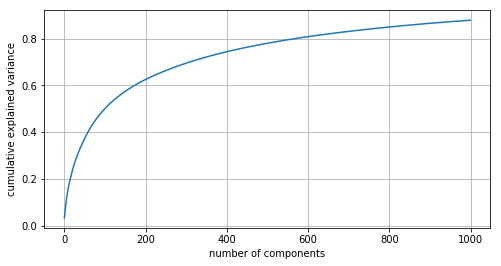

CPU times: user 1min 10s, sys: 20.9 s, total: 1min 31s
Wall time: 33.1 s


In [39]:
%%time
from sklearn.decomposition import TruncatedSVD# IncrementalPCA, PCA
# Veo con 1000 componentes como es la varianza
svd = TruncatedSVD(n_components=1000)
%time svd.fit(X)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

In [40]:
print('Veo que con 500 features abarco el 75% de la varianza')
svd = TruncatedSVD(n_components=500)
%time X = svd.fit_transform(X)
print(X.shape)
del(svd)

Veo que con 500 features abarco el 75% de la varianza
CPU times: user 24.4 s, sys: 12.2 s, total: 36.6 s
Wall time: 12.4 s
(15323, 500)


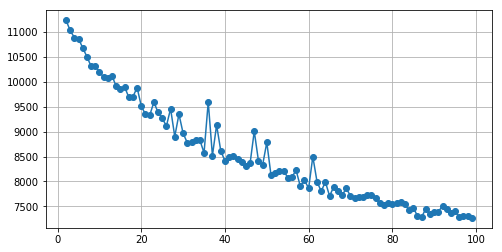

CPU times: user 4min 35s, sys: 5min 53s, total: 10min 28s
Wall time: 2min 42s


In [41]:
%%time
from sklearn.cluster import MiniBatchKMeans
# probando pocos clusters no puede verse un "codo"
clusters = range(2,100)
costs = []
for n_clusters in clusters:
  model = MiniBatchKMeans(n_clusters=n_clusters)
  model.fit(X)
  costs.append(model.inertia_)
plt.figure(figsize=(8,4))
plt.plot(clusters, costs, marker='o')
plt.grid(True)
plt.show()

In [42]:
# tomo 20 clusters
model = MiniBatchKMeans(n_clusters=20)
model.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=20,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [43]:
titulos_dummies = pd.get_dummies(model.labels_)
titulos_dummies.rename(columns=dict([(n,f'titulo_{n+1}') for n in range(len(titulos_dummies.columns))]), inplace=True)
avisos = pd.merge(avisos,titulos_dummies, left_index=True, right_index=True).drop(columns=['titulo'])
avisos.head(3)

,idaviso,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,desc_1,desc_2,desc_3,desc_4,...,titulo_11,titulo_12,titulo_13,titulo_14,titulo_15,titulo_16,titulo_17,titulo_18,titulo_19,titulo_20
0,8725750,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Comercial,VENTOR,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,17903700,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Salud,Farmacias Central Oeste,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1000150677,Capital Federal,Full-time,Senior / Semi-Senior,Transporte,FAMITAX SRL,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [49]:
print(desc_dummies.shape)
print(titulos_dummies.shape)
print(avisos.shape)

(19679, 8)
(15323, 20)
(14047, 34)


In [50]:
avisos.isna().any()

idaviso                 False
nombre_zona             False
tipo_de_trabajo         False
nivel_laboral           False
nombre_area             False
denominacion_empresa    False
desc_1                  False
desc_2                  False
desc_3                  False
desc_4                  False
desc_5                  False
desc_6                  False
desc_7                  False
desc_8                  False
titulo_1                False
titulo_2                False
titulo_3                False
titulo_4                False
titulo_5                False
titulo_6                False
titulo_7                False
titulo_8                False
titulo_9                False
titulo_10               False
titulo_11               False
titulo_12               False
titulo_13               False
titulo_14               False
titulo_15               False
titulo_16               False
titulo_17               False
titulo_18               False
titulo_19               False
titulo_20 

In [ ]:
# EDUCACIÓN
# Analizo valores
nivel_counts = educacion.nivel.value_counts()
print('[nivel]')
for val in nivel_counts.index:
  print(val,' '*(17-len(val)),nivel_counts[val],' '*(7-len(str(nivel_counts[val]))),nivel_counts[val]/len(educacion))

# Reemplazo valor 'Otro' por valor moda
mode = educacion.nivel.mode()[0]
educacion.nivel.replace('Otro', mode, inplace=True)
print()
print('[estado]')
print(educacion.estado.value_counts())

# Convierto valores categóricos a columnas booleanas
nivel = {
  'Doctorado': 6,
   'Master': 5,
   'Posgrado': 4,
   'Universitario': 3,
   'Terciario/Técnico': 2,
   'Secundario': 1
  }
educacion['nivel'] = educacion.nivel.map(lambda x: nivel[x])

estado = {'Graduado': 3,'En Curso': 2, 'Abandonado': 1}
educacion['estado'] = educacion.estado.map(lambda x: estado[x])

In [ ]:
# EDADYGENERO
# Elimino filas con datos faltantes
if(edadYGenero.isna().any().any()):
  edadYGenero.dropna(inplace=True)

# Convierto columnas con fechas a datetime
edadYGenero['fechanacimiento'] = pd.to_datetime(edadYGenero.fechanacimiento, format='%Y/%m/%d', errors='coerce')
if(edadYGenero.isna().any().any()):
  print(edadYGenero.isna().any())
  edadYGenero.dropna(inplace=True)

# Agrego columna edad
anio_actual = pd.to_datetime('today').year
edadYGenero['edad'] = edadYGenero.fechanacimiento.map(lambda fecha: anio_actual - fecha.year).astype(int)

# Elimino la columna fechanacimiento
edadYGenero.drop(columns=['fechanacimiento'], inplace=True)

# Analizo los datos de la columna 'sexo'
print(edadYGenero.sexo.value_counts())
for value in edadYGenero.sexo.value_counts().index:
  if((value != 'FEM') & (value != 'MASC')):
    print(f'tasa [{value}]/total:',len(edadYGenero.sexo[edadYGenero.sexo == value])/len(edadYGenero))

# Reemplazo esos valores por valor moda
moda = edadYGenero.sexo.mode()[0]
print('mode',moda)
edadYGenero.sexo.replace(['NO_DECLARA','0.0'], moda, inplace=True)
print(edadYGenero.sexo.value_counts())

# Elimino filas con id duplicado
if(edadYGenero.idpostulante.duplicated().any()):
  print('total:',len(edadYGenero),'| duplicados:',len(edadYGenero[edadYGenero.idpostulante.duplicated()]))
  print('tasa:',len(edadYGenero[edadYGenero.idpostulante.duplicated()])/len(edadYGenero))
  edadYGenero.drop(edadYGenero[edadYGenero.idpostulante.duplicated()].index, inplace=True)

# Cambio valores categóricos a columnas
genero = {'FEM': 0,'MASC': 1}
edadYGenero['sexo'] = edadYGenero.sexo.map(lambda x: genero[x])

In [ ]:
educacion.estado.isna().any()

In [ ]:
# Busco el nivel de estudio completado más alto
educacion_grouped = educacion.groupby('idpostulante')
# esto está mal
usuarios_edu = educacion_grouped.agg({'nivel': 'max','estado': lambda x: np.count_nonzero(x == 3)}).reset_index()
usuarios_edu.rename(columns={'nivel':'max_nivel_ed','estado':'cant_estudios'}, inplace=True)

In [ ]:
# debería funcionar pero no
[max([val for (ix, val) in enumerate(cols.nivel) if cols.estado[ix] == 3], default=0) for (idx,cols) in educacion_grouped.__iter__()]

In [ ]:
# Analizo las fechas de postulaciónes y vistas
fechas = pd.to_datetime(postulaciones.fechapostulacion)
print('[posts]', ' min:', fechas.min(), '| max:', fechas.max())
fechas = pd.to_datetime(vistas.fechavista)
print('[vistas]', 'min:', fechas.min(), '| max:', fechas.max())

In [ ]:
#vistas.groupby(['idpostulante','idaviso']).count()
vistas.loc[(vistas.idpostulante == '0zB026d') & (vistas.idaviso == 1112358250),:]

In [ ]:
# Unifico vistas y postulaciones
vistas_y_postulaciones = pd.merge(vistas, postulaciones, on=['idpostulante','idaviso'], how='outer')

# Renombro columnas y reordeno
vistas_y_postulaciones.rename(columns={'fechavista':'vista','fechapostulacion':'postulacion'}, inplace=True)
vistas_y_postulaciones = vistas_y_postulaciones[['idaviso','idpostulante','vista','postulacion']]

# Cambio valores de fechas por 1 si hay fecha y 0 si es NaN
vistas_y_postulaciones.vista = vistas_y_postulaciones.vista.notnull().astype('int')
vistas_y_postulaciones.postulacion = vistas_y_postulaciones.postulacion.notnull().astype('int')

In [ ]:
postulaciones.groupby(['idpostulante','idaviso']).count()[lambda x: x.fechapostulacion == 5]

In [ ]:
usr_pos = postulaciones.idpostulante.unique()
usr_info = edadYGenero.idpostulante.unique()
print(len(usr_pos),len(usr_info))